<a href="https://colab.research.google.com/github/max-dev-eng/ResearchPaperRepository/blob/main/Fig_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Circle

# -----------------------
# Geometry / Grid
# -----------------------
L = 0.5                 # 0.5 m x 0.5 m plate
Nx = Ny = 201           # resolution (odd -> exact center)
dx = L / (Nx - 1)
dy = L / (Ny - 1)

x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)     # shape (Ny, Nx)

# Central hole: diameter = 10 cm -> radius = 0.05 m
R = 0.05
cx = cy = L/2
dist2 = (X - cx)**2 + (Y - cy)**2
hole = dist2 <= R**2
solid = ~hole

# -----------------------
# Carbon-ceramic constants
# -----------------------
k = 30.0        # W/(m·K)
rho = 2400.0    # kg/m^3
cp = 800.0      # J/(kg·K)
alpha = k / (rho * cp)

h = 250.0       # W/(m^2·K)
T_inf = 300.0   # ambient (K)
T_init = 500.0  # initial plate temp (K)

# -----------------------
# Time settings
# -----------------------
t_end = 1000.0
snap_dt = 30.0

# Stable explicit timestep (2D FTCS: r <= 1/4 when dx=dy)
dt = 0.24 * dx*dx / alpha
n_steps = int(np.ceil(t_end / dt))
snap_steps = set(int(round(t/dt)) for t in np.arange(0, t_end + 1e-9, snap_dt))

# -----------------------
# Robin / Convective BC using ghost-node elimination
# -k (u_g - u_b)/dx = h(u_b - T_inf)  =>  u_g = u_b - (h dx/k)(u_b - T_inf)
# -----------------------
Bi = h * dx / k

def ghost_from_robin(u_b):
    return u_b - Bi * (u_b - T_inf)

# -----------------------
# Initial condition
# -----------------------
u = np.full((Ny, Nx), T_init, dtype=np.float64)
u[hole] = T_inf  # treat hole interior as ambient fluid

# Fixed color scale across all frames
vmin, vmax = 300.0, 500.0

def step(u):
    # Neighbor arrays
    nE = np.empty_like(u); nW = np.empty_like(u); nN = np.empty_like(u); nS = np.empty_like(u)

    # East/West neighbors
    nE[:, :-1] = u[:, 1:]
    nW[:,  1:] = u[:, :-1]
    nE[:, -1]  = ghost_from_robin(u[:, -1])   # outer right edge (convective)
    nW[:,  0]  = ghost_from_robin(u[:,  0])   # outer left edge (convective)

    # North/South neighbors
    nN[:-1, :] = u[1:, :]
    nS[ 1:, :] = u[:-1, :]
    nN[-1, :]  = ghost_from_robin(u[-1, :])   # outer top edge (convective)
    nS[ 0, :]  = ghost_from_robin(u[ 0, :])   # outer bottom edge (convective)

    # Hole interface: if a solid cell touches a hole cell in a given direction,
    # replace that neighbor by a Robin ghost derived from the solid cell value.
    hole_E = np.zeros_like(hole, dtype=bool); hole_E[:, :-1] = hole[:, 1:]
    hole_W = np.zeros_like(hole, dtype=bool); hole_W[:,  1:] = hole[:, :-1]
    hole_N = np.zeros_like(hole, dtype=bool); hole_N[:-1, :] = hole[1:, :]
    hole_S = np.zeros_like(hole, dtype=bool); hole_S[ 1:, :] = hole[:-1, :]

    mask = solid & hole_E
    nE[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_W
    nW[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_N
    nN[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_S
    nS[mask] = ghost_from_robin(u[mask])

    # FTCS update
    lap = (nE + nW - 2*u)/(dx*dx) + (nN + nS - 2*u)/(dy*dy)
    u_new = u + alpha * dt * lap

    # Keep hole interior fixed at ambient
    u_new[hole] = T_inf
    return u_new

# -----------------------
# Save snapshots to PDF
# -----------------------
pdf_name = "cc_plate_central_hole_500s_30s_fixedscale.pdf"
with PdfPages(pdf_name) as pdf:
    for n in range(n_steps + 1):
        if n in snap_steps:
            t = n * dt
            fig, ax = plt.subplots(figsize=(6, 5))
            u_plot = np.ma.array(u, mask=hole)
            cf = ax.contourf(X, Y, u_plot, levels=60, vmin=vmin, vmax=vmax)
            ax.add_patch(Circle((cx, cy), R, fill=False, linewidth=2))
            ax.set_title(f"Temperature (K) at t = {t:.0f} s")
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_aspect("equal")
            fig.colorbar(cf, ax=ax, label="Temperature (K)")
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

        u = step(u)

print("Saved:", pdf_name)

# If you're in Colab, uncomment to download:
from google.colab import files
files.download(pdf_name)

Saved: cc_plate_central_hole_500s_30s_fixedscale.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

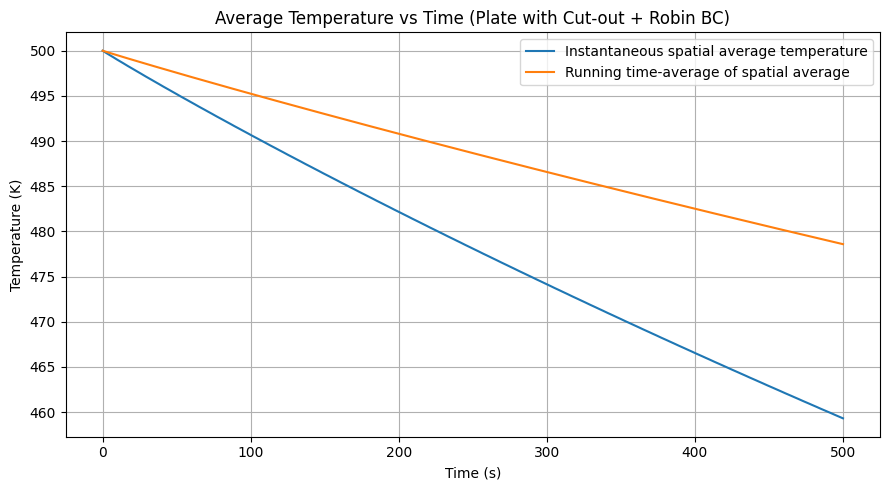

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Geometry / Grid
# -----------------------
L = 0.5
Nx = Ny = 201
dx = L / (Nx - 1)
dy = L / (Ny - 1)

x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Central cut-out hole (diameter 10 cm)
R = 0.05
cx = cy = L / 2
dist2 = (X - cx)**2 + (Y - cy)**2
hole = dist2 <= R**2
solid = ~hole

# -----------------------
# Material / Convection
# -----------------------
k = 30.0
rho = 2400.0
cp = 800.0
alpha = k / (rho * cp)

h = 100.0
T_inf = 300.0
T_init = 500.0

# -----------------------
# Time settings
# -----------------------
t_end = 500.0

# Stable explicit dt (2D FTCS, dx=dy): r <= 1/4
dt = 0.24 * dx*dx / alpha
n_steps = int(np.ceil(t_end / dt))

# Record data at (approximately) 1-second intervals for a clean plot
record_dt = 1.0  # seconds
next_record_time = 0.0

# -----------------------
# Robin BC via ghost-node elimination
# -k (u_g - u_b)/dx = h (u_b - T_inf)
# => u_g = u_b - (h dx/k)(u_b - T_inf)
# -----------------------
Bi = h * dx / k

def ghost_from_robin(u_b):
    return u_b - Bi * (u_b - T_inf)

# -----------------------
# Initial condition: solid only; hole is void (NaN)
# -----------------------
u = np.full((Ny, Nx), np.nan, dtype=np.float64)
u[solid] = T_init

def step(u):
    # neighbor arrays
    nE = np.empty_like(u)
    nW = np.empty_like(u)
    nN = np.empty_like(u)
    nS = np.empty_like(u)

    # shift neighbors (may introduce NaNs where neighbor is hole)
    nE[:, :-1] = u[:, 1:]
    nW[:,  1:] = u[:, :-1]
    nN[:-1, :] = u[1:, :]
    nS[ 1:, :] = u[:-1, :]

    # outer edges: convective ghost
    nE[:, -1] = ghost_from_robin(u[:, -1])
    nW[:,  0] = ghost_from_robin(u[:,  0])
    nN[-1, :] = ghost_from_robin(u[-1, :])
    nS[ 0, :] = ghost_from_robin(u[ 0, :])

    # hole adjacency masks (where a solid cell's neighbor lies in the hole)
    hole_E = np.zeros_like(hole, dtype=bool); hole_E[:, :-1] = hole[:, 1:]
    hole_W = np.zeros_like(hole, dtype=bool); hole_W[:,  1:] = hole[:, :-1]
    hole_N = np.zeros_like(hole, dtype=bool); hole_N[:-1, :] = hole[1:, :]
    hole_S = np.zeros_like(hole, dtype=bool); hole_S[ 1:, :] = hole[:-1, :]

    mask = solid & hole_E
    nE[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_W
    nW[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_N
    nN[mask] = ghost_from_robin(u[mask])

    mask = solid & hole_S
    nS[mask] = ghost_from_robin(u[mask])

    # Laplacian
    lap = (nE + nW - 2*u)/(dx*dx) + (nN + nS - 2*u)/(dy*dy)

    u_new = u.copy()
    u_new[solid] = u[solid] + alpha * dt * lap[solid]
    u_new[hole] = np.nan
    return u_new

# -----------------------
# Run + collect time series
# -----------------------
times = []
meanT = []

t = 0.0
for n in range(n_steps + 1):
    # record at ~each second
    if t + 1e-12 >= next_record_time:
        times.append(next_record_time)
        meanT.append(np.nanmean(u))  # spatial mean over solid (hole is NaN)
        next_record_time += record_dt
        if next_record_time > t_end + 1e-12:
            break

    # advance
    u = step(u)
    t += dt

times = np.array(times, dtype=float)
meanT = np.array(meanT, dtype=float)

# -----------------------
# Running time-average of mean temperature:
# avg(t) = (1/t) ∫_0^t meanT(τ) dτ
# Approximate with trapezoidal rule on the recorded points
# -----------------------
run_avg = np.zeros_like(meanT)
area = 0.0
for i in range(len(times)):
    if i == 0:
        run_avg[i] = meanT[i]
    else:
        dt_i = times[i] - times[i-1]
        area += 0.5 * (meanT[i] + meanT[i-1]) * dt_i
        run_avg[i] = area / times[i]  # average up to time[i]

# -----------------------
# Plot: mean temperature + running time-average on same axes
# -----------------------
plt.figure(figsize=(9, 5))
plt.plot(times, meanT, label="Instantaneous spatial average temperature")
plt.plot(times, run_avg, label="Running time-average of spatial average")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("Average Temperature vs Time (Plate with Cut-out + Robin BC)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()